<a href="https://colab.research.google.com/github/apashea/LSTM-Neural-Network-for-Predicting-QCLN-adjusted-closing-price/blob/main/LSTM_Neural_Network_for_Predicting_QCLN_adjusted_closing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the adjust closing of the NASDAQ Clean Edge Green Energy index by iterating over
#              the past 60 day stock price.
#              LSTMs are often used to predict sequences of data (with NN's generally being more advanced in
#              their ability to process sequences of data instead of just individual points.) They can remember
#              important information and forget unimportant information. 

In [2]:
# Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# Use a custom pre-made plot style
plt.style.use('fivethirtyeight')

In [3]:
# Get stock quote running from the start of the QCLN data to yesterday.
# Later we will predict today's adjusted closing price.
df = web.DataReader('QCLN', data_source='yahoo', start='2007-02-14', end='2021-04-11')
# Show stock data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-02-14,20.000000,19.799999,19.799999,19.940001,5600.0,18.495649
2007-02-15,20.000000,19.870001,19.950001,19.940001,33300.0,18.495649
2007-02-16,22.010000,19.930000,19.930000,20.030001,129700.0,18.579128
2007-02-20,20.309999,19.950001,20.129999,20.270000,74300.0,18.801743
2007-02-21,20.459999,20.219999,20.240000,20.430000,49000.0,18.950159
...,...,...,...,...,...,...
2021-04-05,70.970001,67.809998,70.970001,68.019997,712400.0,68.019997
2021-04-06,69.709999,68.169998,68.199997,68.940002,656900.0,68.940002
2021-04-07,68.900002,65.820000,68.750000,66.190002,609000.0,66.190002


In [4]:
# See number of rows and columns in data
df.shape

(3563, 6)

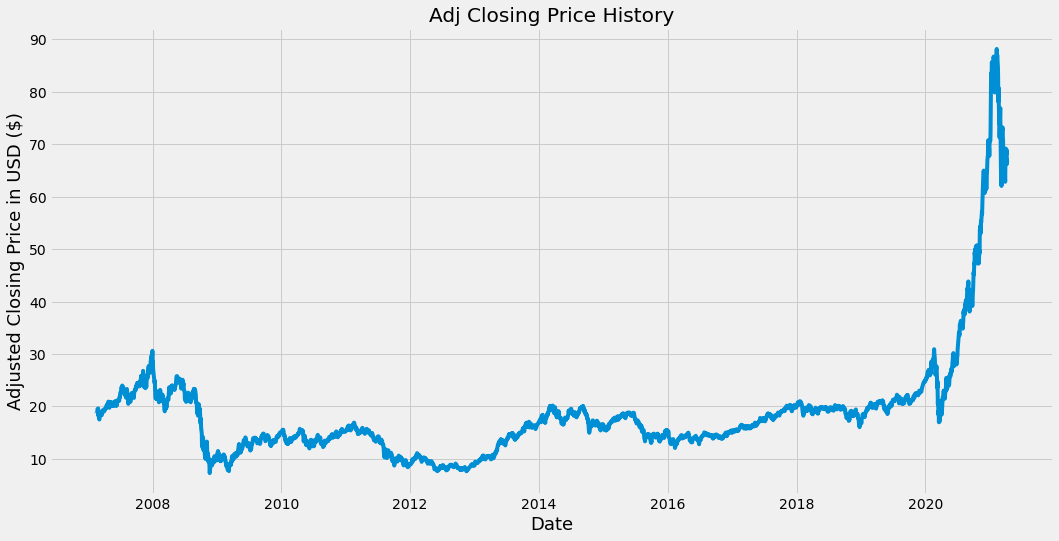

In [5]:
# Visualize adjusted closing price history
plt.figure(figsize=(16,8))
plt.title('Adj Closing Price History')
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adjusted Closing Price in USD ($)', fontsize = 18)
plt.show()

In [6]:
# Create a new dataframe with only the 'Adj Close' column
data = df.filter(['Adj Close'])
# Convert data to a numpy array
dataset = data.values
# Get number of rows to train the model. Setting to .8 takes only the first
# 80% of the data and math.ceil rounds up the product.
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

2851

In [7]:
# Scale the data, which is always good practice to do before processing the data
scaler = MinMaxScaler(feature_range=(0,1))          # values between 0 and 1
scaled_data = scaler.fit_transform(dataset)         # Holds scaled data             
# Show the first and last values of the scaled array
scaled_data

array([[0.13853956],
       [0.13853956],
       [0.1395717 ],
       ...,
       [0.72823719],
       [0.73998304],
       [0.73293551]])

In [8]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len,:]   # starts at start, limit at training_data_len, and return all columns
# Split the data into x_train and y_train datasets first by creating empty lists
x_train = []    # will be independent training variables/features
y_train = []    # will be dependent/target variabl

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])   # will contain past 60 values indexed from 0
  y_train.append(train_data[i, 0])        # will contain 61st value (at position 60)
#  if i<= 60:
#    print(x_train)
#    print(y_train)
#    print()

In [9]:
# Convert x_train and y_train to numpy arrays for LSTM model training
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the data (LSTM expects 3-dimensional, not 2-dimensional, data)

# Check number of rows and columns
x_train.shape
# Reshape x_train with 2792 samples (# of rows, found in first value of x_train.shape), 
# 60 real-time steps (# of columns, found in second value of x_train.shape), 
# and 1 feature (Adj Close)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2791, 60, 1)

In [ ]:
# Build the LSTM model's architecture
model = Sequential()
# Add the LSTM layer with 50 neurons, return_sequences as True because we'll use
# another LSTM layer, and input shape as number of time steps (60) and 1 feature
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Add second and final LSTM layer, also with 50 neurons
model.add(LSTM(50, return_sequences=False))
# Add dense layer with 25 neurons
model.add(Dense(25))
# Add second dense layer with a single neuron
model.add(Dense(1))

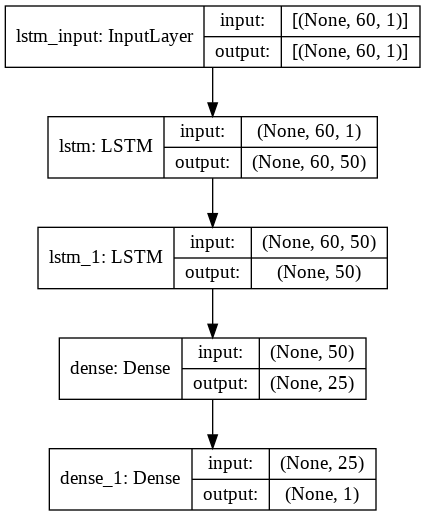

In [25]:
# Visualize our model's architecture
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
# Compile the model with adam optimizer (used to improve upon the loss function)
# and mean squared error loss function (to measure model's training performance)
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model with 1 epoch (single iteration of entire dataset being passed
# forward and backward)
model.fit(x_train, y_train, batch_size=1, epochs=1)

2791/2791 [==============================] - 71s 24ms/step - loss: 2.3028e-04


In [14]:
# Create the testing dataset

# Create a new array containing scaled values from index 2792 to 3564 (roughly
# the last 20% of our entire dataset)
test_data = scaled_data[training_data_len - 60:,:]
# Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])  

In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the test data to 3 dimensions
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Get models predicted adjusted closing price values. Remember we want them to
# correspond with the values in our test dataset.
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)   # unscaling the values afterward.

In [18]:
# Get the root mean squared error (RMSE), a common measure of error
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.801929837964378

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


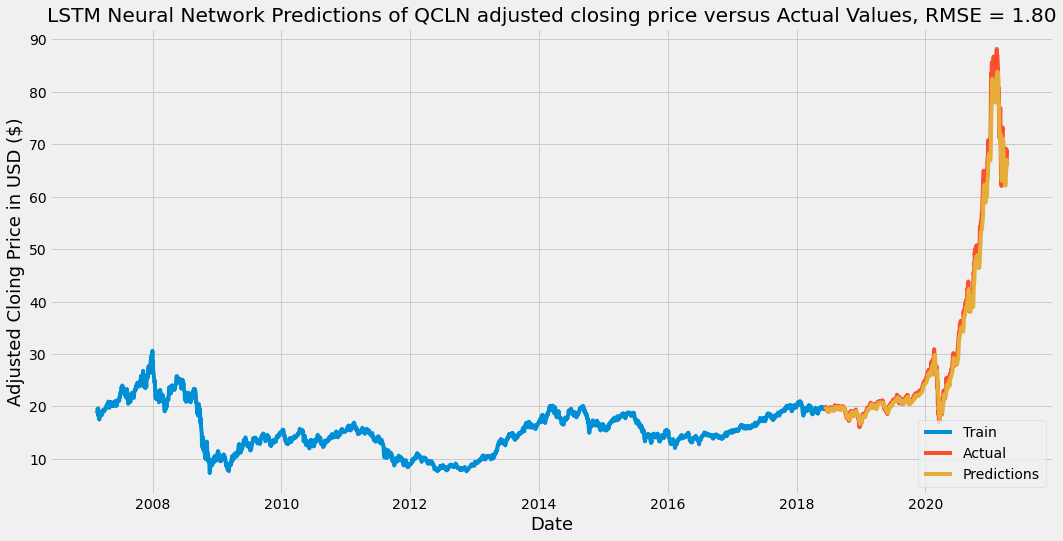

In [24]:
# Plot the data
train = data[:training_data_len]    # runs from zero to max of training data
valid = data[training_data_len:]    # runs from post-training data to end
valid['Predictions'] = predictions  # create new column in valid object
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM Neural Network Predictions of QCLN adjusted closing price versus Actual Values, RMSE = 1.80')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adjusted Cloing Price in USD ($)', fontsize = 18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [20]:
# Show the actual versus predicted prices via df we created containing each
valid

,Adj Close,Predictions
Date,,
2018-06-12,19.714632,19.432222
2018-06-13,19.763388,19.466606
2018-06-14,19.919384,19.526592
2018-06-15,19.646383,19.621580
2018-06-18,19.821884,19.635035
...,...,...
2021-04-05,68.019997,65.575783
2021-04-06,68.940002,66.424164
2021-04-07,66.190002,67.018036


In [21]:
# Predicting April 12th adjusted closing price 
# (Note: could instead reuse some variables from above 
# but reloading the original data helps us to avoid accidental modification of
# previous objects.)

# Get the quote
qcln_quote = web.DataReader('QCLN', data_source='yahoo', start='2007-02-14', end='2021-04-11')
# Create a new fataframe
new_df = qcln_quote.filter(['Adj Close'])
# Get last 60 day closing price values and convert to an array
last_60_days = new_df[-60:].values
# Scale data
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append scaled past 60 days
X_test.append(last_60_days_scaled)
# Convert to numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[65.23364]]


In [22]:
# April 12th's actual adjusted closing price
qcln_quote2 = web.DataReader('QCLN', data_source='yahoo', start='2021-04-12', end='2021-04-12')
print(qcln_quote2['Adj Close'])

Date
2021-04-12    65.68
Name: Adj Close, dtype: float64
